In [100]:
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.text import Annotation
from matplotlib.patches import FancyArrowPatch
import matplotlib.patches as mpatches
from numpy import matlib

DATA_DIMENSION = 3
argument_resolution = 256

class Annotation3D(Annotation):
    def __init__(self, text, xyz, *args, **kwargs):
        super().__init__(text, xy=(0,0), *args, **kwargs)
        self._xyz = xyz
 
    def draw(self, renderer):
        x2, y2, z2 = proj_transform(*self._xyz, renderer.M)
        self.xy=(x2,y2)
        super().draw(renderer)
 
def _annotate3D(ax,text, xyz, *args, **kwargs):
    '''Add anotation `text` to an `Axes3d` instance.'''
 
    annotation= Annotation3D(text, xyz, *args, **kwargs)
    ax.add_artist(annotation)
 
setattr(Axes3D,'annotate3D',_annotate3D)
 
class Arrow3D(FancyArrowPatch):
    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._xyz = (x,y,z)
        self._dxdydz = (dx,dy,dz)
 
    def draw(self, renderer):
        x1,y1,z1 = self._xyz
        dx,dy,dz = self._dxdydz
        x2,y2,z2 = (x1+dx,y1+dy,z1+dz)
 
        xs, ys, zs = proj_transform((x1,x2),(y1,y2),(z1,z2), renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        super().draw(renderer)
 
def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''
 
    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)
 
setattr(Axes3D,'arrow3D',_arrow3D)

class ellipsoid:
    def __init__(self, if_draw=False):
        super(ellipsoid, self).__init__()
        self.phi = np.linspace(0,2 *np.pi, argument_resolution).reshape(argument_resolution, 1) # the angle of the projection in the xy-plane 
        self.theta = np.linspace(0, np.pi, argument_resolution).reshape(-1, argument_resolution) # the angle from the polar axis, ie the polar angle 

        u = np.linspace(0, 2 * np.pi, 100)
        v = np.linspace(0, np.pi, 100)
        
        self.x = np.outer(np.cos(u), np.sin(v)) 
        self.y = np.outer(np.sin(u), np.sin(v))
        self.z_iterated = np.outer(np.ones(np.size(u)), np.cos(v))

        if(if_draw):
            self.fig = plt.figure(figsize=(20, 20)) # Square figure 
            self.ax = self.fig.add_subplot(111, projection='3d')


        
    def draw_ellipsoid(self, unit_ellipsoid_axes, radius_list, ellipsoid_center, if_draw_axes=False):
        x_transformed, y_transformed, z_transformed = np.zeros(self.x.shape), np.zeros(self.y.shape), np.zeros(self.z_iterated.shape)
        wire_frame_coordinates = np.stack([self.x*radius_list[0], self.y*radius_list[1], self.z_iterated*radius_list[2]]).transpose([1, 2, 0])
        
        for i in range(len(self.x)):
            for j in range(len(self.y)):
                x_transformed[i][j], y_transformed[i][j], z_transformed[i][j] = np.dot((unit_ellipsoid_axes), wire_frame_coordinates[i][j]) + ellipsoid_center[0]
                temp = np.dot((unit_ellipsoid_axes), wire_frame_coordinates[i][j])
                #print(np.linalg.norm(temp))
        wire_frame_coordinates = np.stack([x_transformed , y_transformed, z_transformed])
                        
        if(if_draw_axes):   
            
            self.ax.arrow3D(ellipsoid_center[0][0], ellipsoid_center[0][1], ellipsoid_center[0][2], unit_ellipsoid_axes[0][0]*radius_list[0], unit_ellipsoid_axes[1][0]*radius_list[0], unit_ellipsoid_axes[2][0]*radius_list[0],
                       mutation_scale=20,  arrowstyle="-|>", fc='orange', ec='orange', lw = 5)
            self.ax.arrow3D(ellipsoid_center[0][0], ellipsoid_center[0][1], ellipsoid_center[0][2], unit_ellipsoid_axes[0][1]*radius_list[1], unit_ellipsoid_axes[1][1]*radius_list[1], unit_ellipsoid_axes[2][1]*radius_list[1],
                       mutation_scale=20, arrowstyle="-|>", fc='orange', ec='orange', lw = 5)
            self.ax.arrow3D(ellipsoid_center[0][0], ellipsoid_center[0][1], ellipsoid_center[0][2], unit_ellipsoid_axes[0][2]*radius_list[2], unit_ellipsoid_axes[1][2]*radius_list[2], unit_ellipsoid_axes[2][2]*radius_list[2],
                       mutation_scale=20, arrowstyle="-|>", fc='orange', ec='orange', lw = 5)

            self.ax.text(ellipsoid_center[0][0]+unit_ellipsoid_axes[0][0] , ellipsoid_center[0][1]+unit_ellipsoid_axes[0][1], ellipsoid_center[0][2]+unit_ellipsoid_axes[0][2], r'$v_0$', fontsize=20)
            self.ax.text(ellipsoid_center[0][0]+unit_ellipsoid_axes[1][0] , ellipsoid_center[0][1]+unit_ellipsoid_axes[1][1], ellipsoid_center[0][2]+unit_ellipsoid_axes[1][2], r'$v_1$', fontsize=20)
            self.ax.text(ellipsoid_center[0][0]+unit_ellipsoid_axes[2][0] , ellipsoid_center[0][1]+unit_ellipsoid_axes[2][1], ellipsoid_center[0][2]+unit_ellipsoid_axes[2][2], r'$v_2$', fontsize=20)
            
            #self.ax.plot_wireframe(wire_frame_coordinates[0], wire_frame_coordinates[1], wire_frame_coordinates[2], color='black',rcount=10, ccount=10) 
            self.ax.plot_wireframe(x_transformed, y_transformed, z_transformed, color='black',rcount=10, ccount=10) 


        grid_range = 10

        self.ax.set_xlabel('x', fontsize=30)
        self.ax.set_ylabel('y', fontsize=30)
        self.ax.set_zlabel('z', fontsize=30)
        
    def draw_film(self, x, y, z, random_normal_coordinates):
        wire_density = 10
        self.ax.plot_wireframe(x, y, z,rcount=wire_density, ccount=wire_density, antialiased=False)
        self.ax.scatter(random_normal_coordinates[:, 0], random_normal_coordinates[:, 1], random_normal_coordinates[:, 2], color='red', s=100)
      
    def show(self, grid_range=10, elev=45, azim=45):
        self.ax.set_xlabel('x', fontsize=30)
        self.ax.set_ylabel('y', fontsize=30)
        self.ax.set_zlabel('z', fontsize=30)
        self.ax.set_xlim(-grid_range, grid_range)
        self.ax.set_ylim(-grid_range, grid_range)
        self.ax.set_zlim(-grid_range, grid_range)
        self.ax.view_init(elev = elev, azim=azim)
        plt.show()
               
def grape_piece_moment(start_point, center_of_piece):
    orthonormal_matrix, _ = np.linalg.qr(np.c_[(center_of_piece - start_point).T, np.ones((3, 2))])
    if(int(np.sign(orthonormal_matrix[0][0]))!=int(np.sign(center_of_piece-start_point)[0][0])):
        orthonormal_matrix = -orthonormal_matrix
    radius=5
    berry_size_noise = 0.06
    radius_list = np.array([0.6, 0.3, 0.4]) + np.random.normal(0, berry_size_noise, 3)
    radius_list = radius_list*radius
    return orthonormal_matrix.T, radius_list

In [101]:
def make_small_grape_bunch(center_of_bunch, alpha, beta, number_of_random_points, interval):
    
    
    radius = np.linalg.norm(center_of_bunch)
    theta = np.arccos(center_of_bunch[2]/radius)
    phi = np.sign(center_of_bunch[1])*np.arccos(center_of_bunch[0] / np.linalg.norm(center_of_bunch[:2]) )
    
    u = np.linspace(phi - np.pi*alpha/5 , phi + np.pi*alpha/5, 100)
    v = np.linspace(theta - np.pi*beta/5 ,theta + np.pi*beta/5, 100)
    x = radius * np.outer(np.cos(u), np.sin(v))
    y = radius * np.outer(np.sin(u), np.sin(v))
    z = radius * np.outer(np.ones(np.size(u)), np.cos(v))

    polar_coordinates =  np.stack([x, y, z]).transpose([1, 2, 0]) 

    #random_polar_coordinates = np.random.randint(0,100,size=[number_of_random_points,2])
    random_normal_coordinates  = polar_coordinates[tuple(np.random.randint(0, 100, 2))].reshape((1, 3))

    berry_piece_interval = interval
    iter_threshold = 1000

    cnt = 1
    iter_counter = 0
    iter_thresh = 10000

    while(cnt<=number_of_random_points):
        
        normal_coordinate_temp = polar_coordinates[tuple(np.random.randint(0, 100, 2))].reshape((1, 3))
        #print(polar_coordinate_temp.shape)
    
        if(np.count_nonzero(np.sqrt(((random_normal_coordinates[:cnt]-normal_coordinate_temp)**2).sum(axis=1)) > berry_piece_interval)==cnt):
            random_normal_coordinates[cnt-1] = normal_coordinate_temp
            random_normal_coordinates=np.concatenate((random_normal_coordinates, normal_coordinate_temp), axis=0)
            cnt = cnt + 1
        
        iter_counter = iter_counter + 1
    
        if(iter_counter > iter_thresh):
            break
            
    
    return random_normal_coordinates, x, y, z
    
    
    

In [106]:
def make_grape_stem(number_of_random_points, interval):
    
    #alpha, beta = 1, 1
    
    radius = 20
    radius_list = np.array([0.2, 0.4, 0.6])*radius

    u = np.linspace(0, 2*np.pi, 100)
    v = np.linspace(0 ,np.pi, 100)
    x = radius_list[0] * np.outer(np.cos(u), np.sin(v))
    y = radius_list[1] * np.outer(np.sin(u), np.sin(v))
    z = radius_list[2] * np.outer(np.ones(np.size(u)), np.cos(v))


    polar_coordinates =  np.stack([x, y, z]).transpose([1, 2, 0]) 

    #random_polar_coordinates = np.random.randint(0,100,size=[number_of_random_points,2])
    random_normal_coordinates  = polar_coordinates[tuple(np.random.randint(0, 100, 2))].reshape((1, 3))

    berry_piece_interval = interval
    iter_threshold = 1000

    cnt = 1
    iter_counter = 0
    iter_thresh = 10000

    while(cnt<=number_of_random_points):
        
        normal_coordinate_temp = polar_coordinates[tuple(np.random.randint(0, 100, 2))].reshape((1, 3))
        #print(polar_coordinate_temp.shape)
    
        if(np.count_nonzero(np.sqrt(((random_normal_coordinates[:cnt]-normal_coordinate_temp)**2).sum(axis=1)) > berry_piece_interval)==cnt):
            random_normal_coordinates[cnt-1] = normal_coordinate_temp
            random_normal_coordinates=np.concatenate((random_normal_coordinates, normal_coordinate_temp), axis=0)
            cnt = cnt + 1
        
        iter_counter = iter_counter + 1
    
        if(iter_counter > iter_thresh):
            break
            
    
    return random_normal_coordinates, x, y, z
    
    

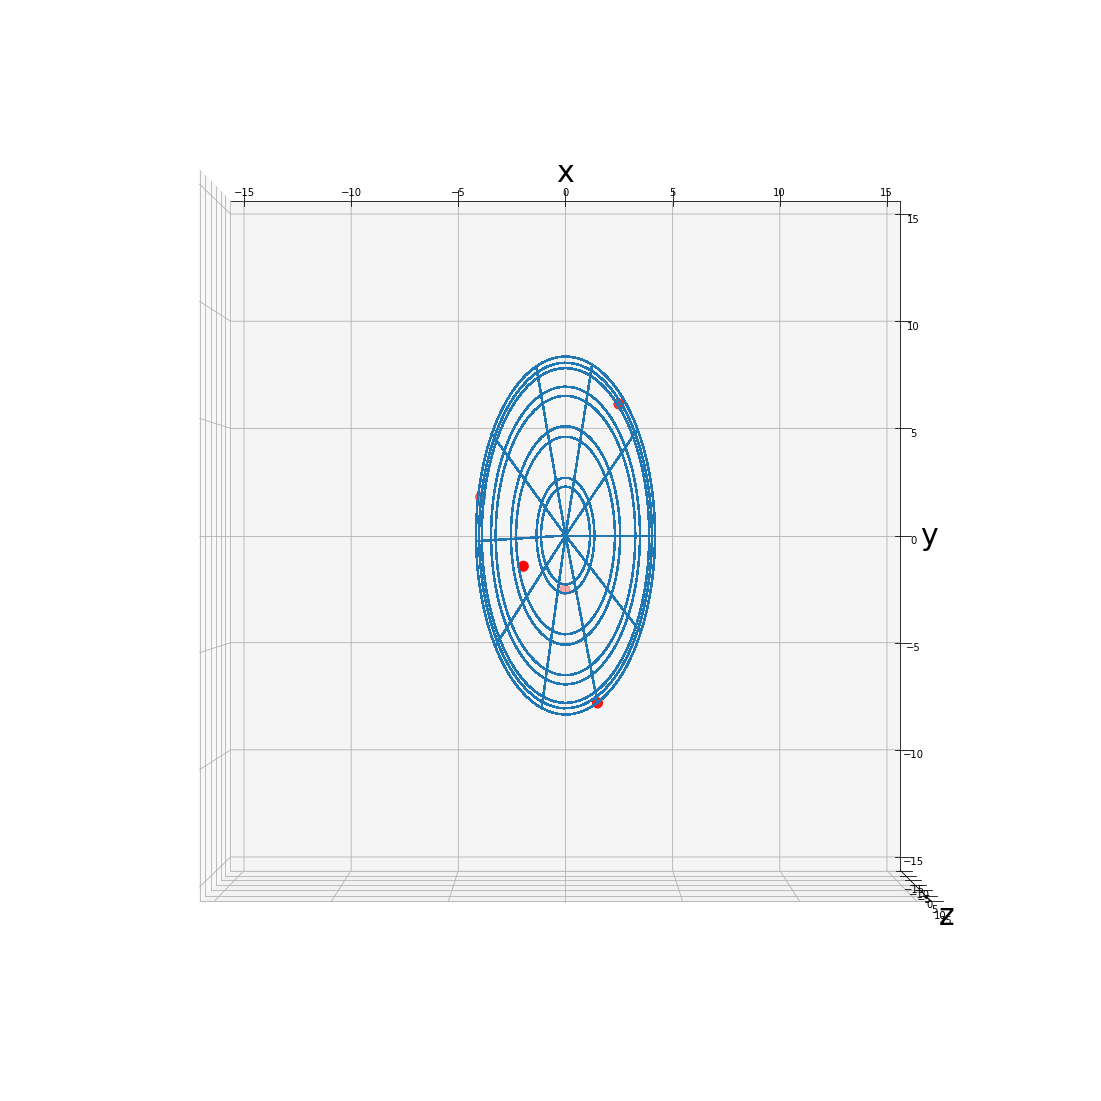

In [115]:
number_of_random_points = 20
interval = 10
small_bunch_list, x, y, z = make_grape_stem(number_of_random_points, interval)
ellipsoid_stem = ellipsoid(if_draw=True)
ellipsoid_stem.draw_film(x, y, z, small_bunch_list)
ellipsoid_stem.show(grid_range, elev=90, azim=-90)

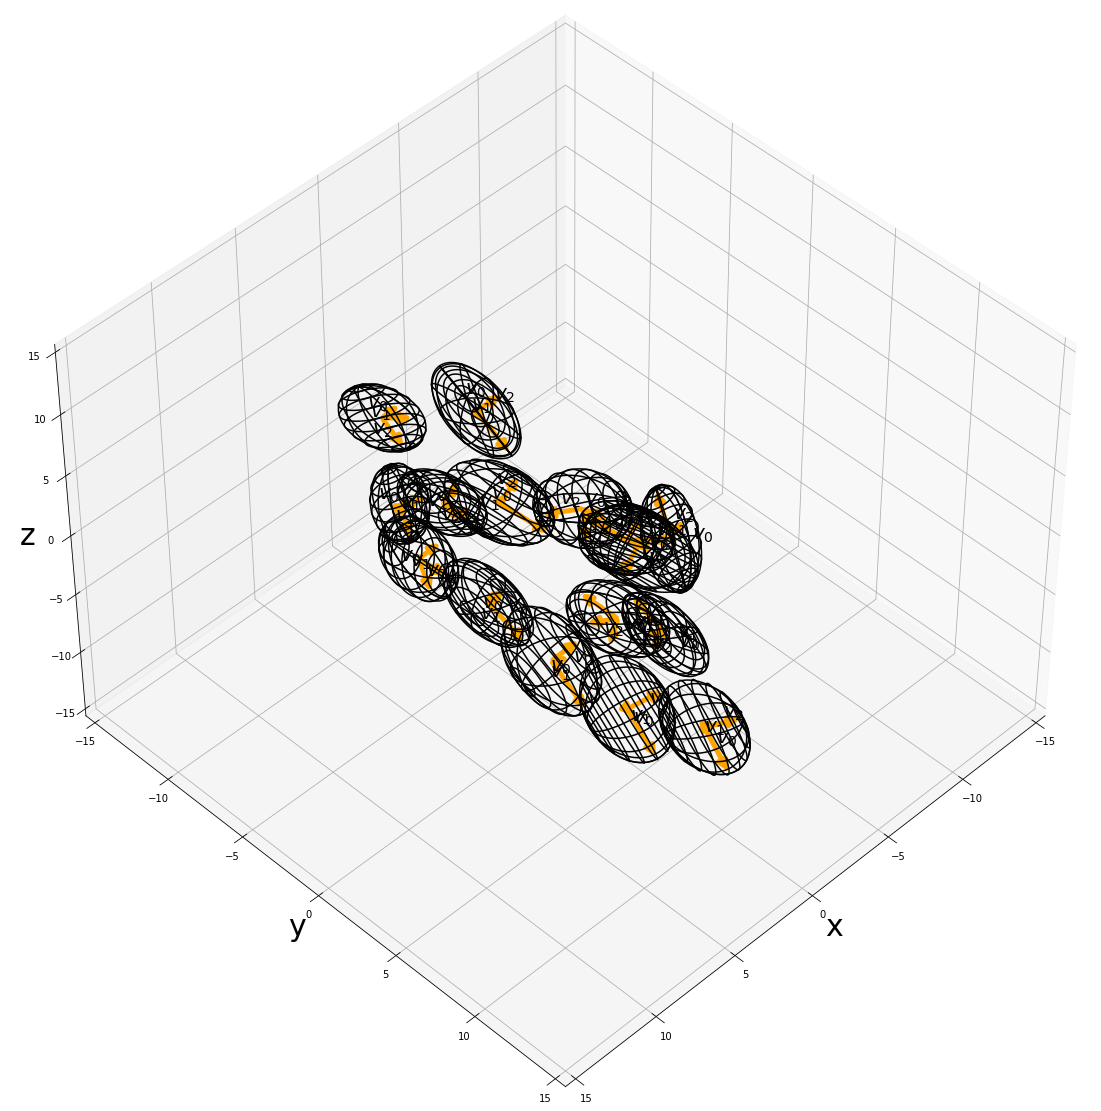

In [116]:

ellipsoid_test = ellipsoid(if_draw=True)


for j in range(small_bunch_list.shape[0]-1):
    alpha, beta = np.random.normal(0, 1, 2)
    number_of_random_points = 5
    interval = 3
    random_normal_coordinates, x, y, z = make_small_grape_bunch(small_bunch_list[j], alpha, beta, number_of_random_points, interval)
    
    
    for i in range(len(random_normal_coordinates)-1):
        start_point = np.zeros(3)
        center_of_piece = np.array([random_normal_coordinates[i]])
        unit_ellipsoid_axes, radius_list = grape_piece_moment(start_point, center_of_piece)
        ellipsoid_test.draw_ellipsoid(unit_ellipsoid_axes, radius_list, center_of_piece, if_draw_axes=True)
        #ellipsoid_test.draw_film(x, y, z, random_normal_coordinates)
    
    #ellipsoid_test.draw_film(x, y, z, random_normal_coordinates)
    
grid_range = 15
#ellipsoid_test.show(grid_range,  elev=90, azim=-90)
ellipsoid_test.show(grid_range)

   

In [94]:
small_bunch_list.shape

(14, 3)

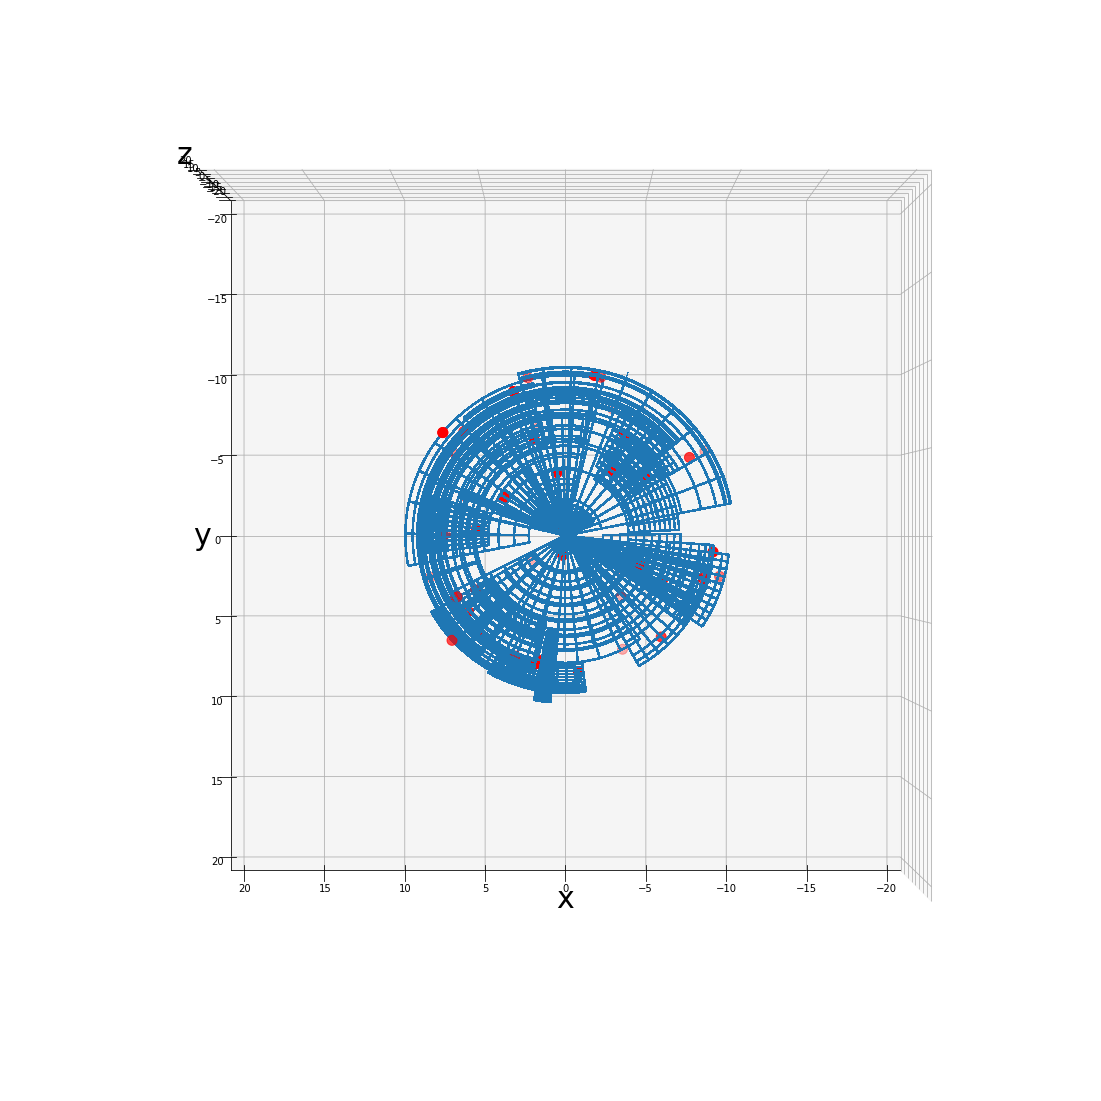

In [95]:
number_of_random_points = 20
interval = 5
small_bunch_list, x, y, z = make_grape_stem(number_of_random_points, interval)

ellipsoid_test = ellipsoid(if_draw=True)


for j in range(small_bunch_list.shape[0]-1):
    alpha, beta = np.random.normal(0, 1, 2)
    number_of_random_points = 5
    interval = 7
    random_normal_coordinates, x, y, z = make_small_grape_bunch(small_bunch_list[j], alpha, beta, number_of_random_points, interval)
    
    
    for i in range(len(random_normal_coordinates)-1):
        start_point = np.zeros(3)
        center_of_piece = np.array([random_normal_coordinates[i]])
        unit_ellipsoid_axes, radius_list = grape_piece_moment(start_point, center_of_piece)
        ellipsoid_test.draw_ellipsoid(unit_ellipsoid_axes, radius_list, center_of_piece)
        #ellipsoid_test.draw_film(x, y, z, random_normal_coordinates)
    
    ellipsoid_test.draw_film(x, y, z, random_normal_coordinates)
    
grid_range = 20
ellipsoid_test.show(grid_range, elev=90, azim=90)
    

22.9128784747792
115.87669006082751
-165.96375653207352
[[-19.78489441  -6.07764563  -9.82955628]]
(1, 3)


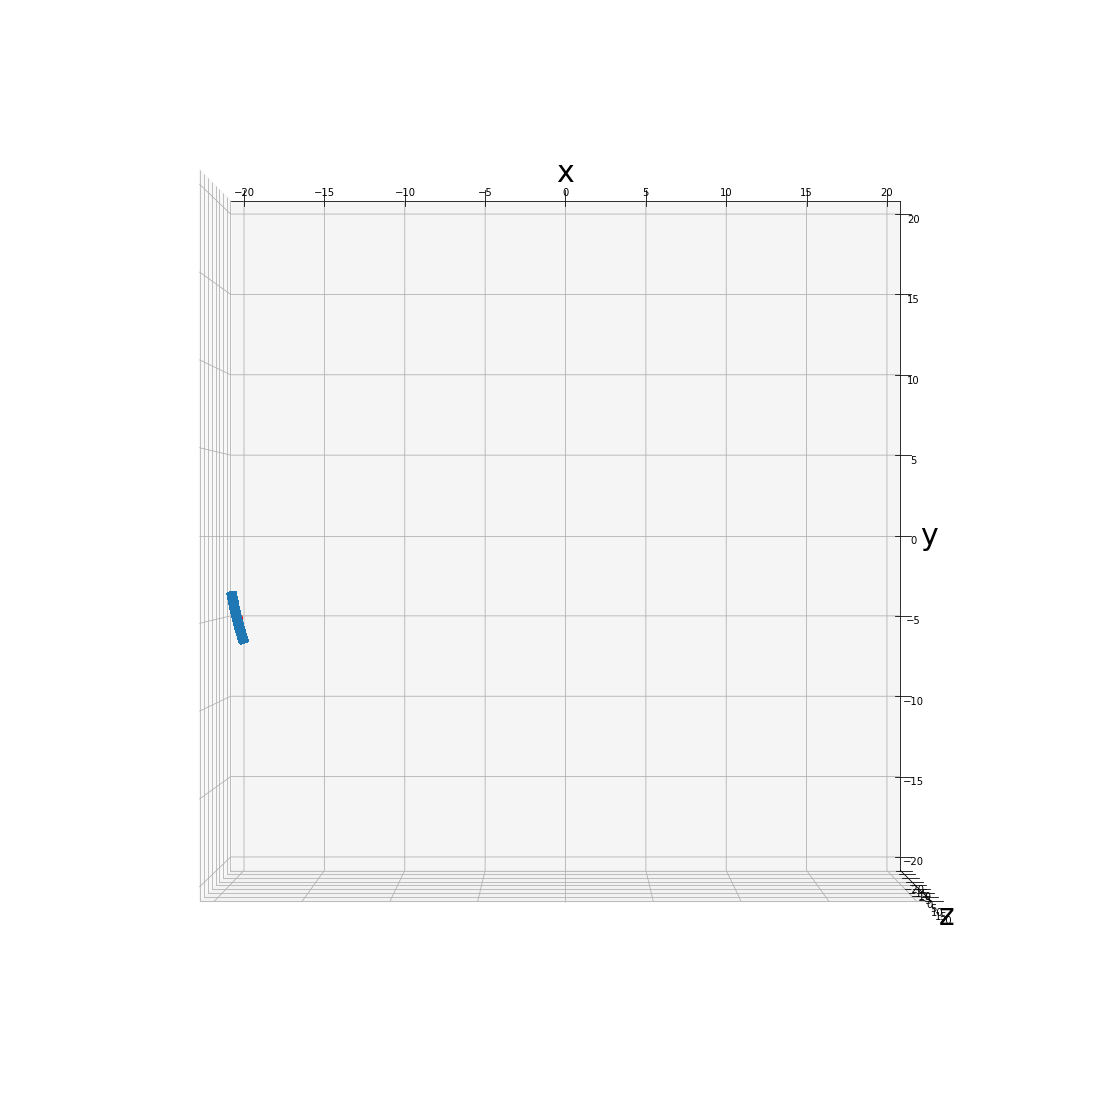

In [86]:

ellipsoid_test = ellipsoid(if_draw=True)

alpha, beta = np.random.normal(0, 0.1, 2)
number_of_random_points = 5
interval = 7
random_normal_coordinates, x, y, z = make_small_grape_bunch(np.array([-20, -5, -10]), alpha, beta, number_of_random_points, interval)
print(random_normal_coordinates) 
    
for i in range(len(random_normal_coordinates)-1):
    start_point = np.zeros(3)
    center_of_piece = np.array([random_normal_coordinates[i]])
    unit_ellipsoid_axes, radius_list = grape_piece_moment(start_point, center_of_piece)
    ellipsoid_test.draw_ellipsoid(unit_ellipsoid_axes, radius_list, center_of_piece)
    #ellipsoid_test.draw_film(x, y, z, random_normal_coordinates)
    
print(random_normal_coordinates.shape)
#ellipsoid_test.draw_film(x, y, z, random_normal_coordinates)
ellipsoid_test.draw_film(x, y, z, np.array([[-20, -5, -10]]))



grid_range = 20
ellipsoid_test.show(grid_range, elev=90, azim=-90)    

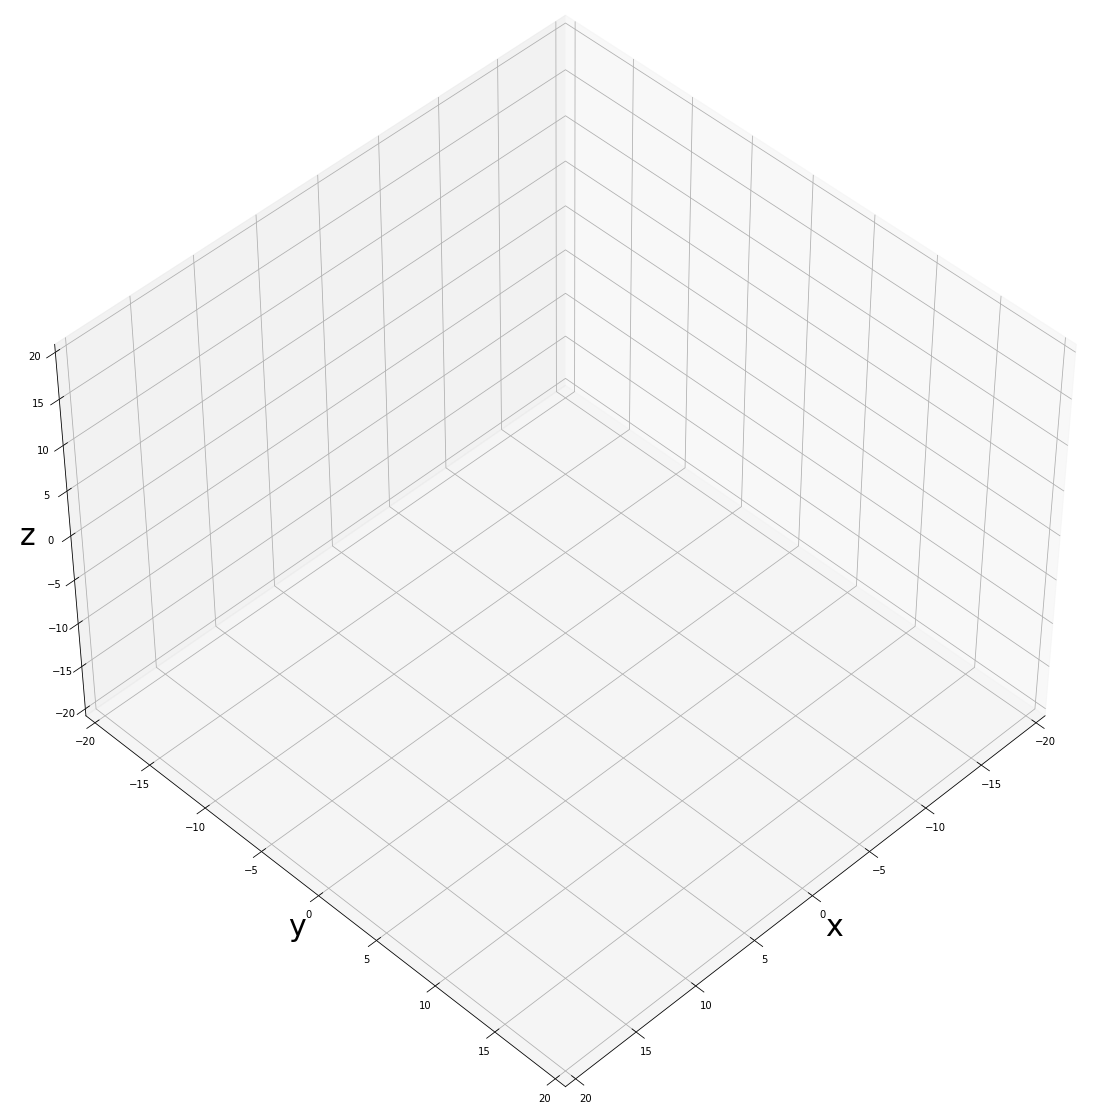

In [6]:
number_of_random_points = 20
interval = 6
small_bunch_list, x, y, z = make_grape_stem(number_of_random_points, interval)

ellipsoid_test = ellipsoid(if_draw=True)


for j in range(small_bunch_list.shape[0]-1):
    alpha, beta = np.random.normal(0, 1, 2)
    number_of_random_points = 5
    interval = 5
    random_normal_coordinates, x, y, z = make_small_grape_bunch(small_bunch_list[j], alpha, beta, number_of_random_points, interval)
    
    
    for i in range(len(random_normal_coordinates)-1):
        start_point = np.zeros(3)
        center_of_piece = np.array([random_normal_coordinates[i]])
        unit_ellipsoid_axes, radius_list = grape_piece_moment(start_point, center_of_piece)
        ellipsoid_test.draw_ellipsoid(unit_ellipsoid_axes, radius_list, center_of_piece)
        #ellipsoid_test.draw_film(x, y, z, random_normal_coordinates)
    
    #ellipsoid_test.draw_film(x, y, z, random_normal_coordinates)
    
grid_range = 20
ellipsoid_test.show(grid_range)
    

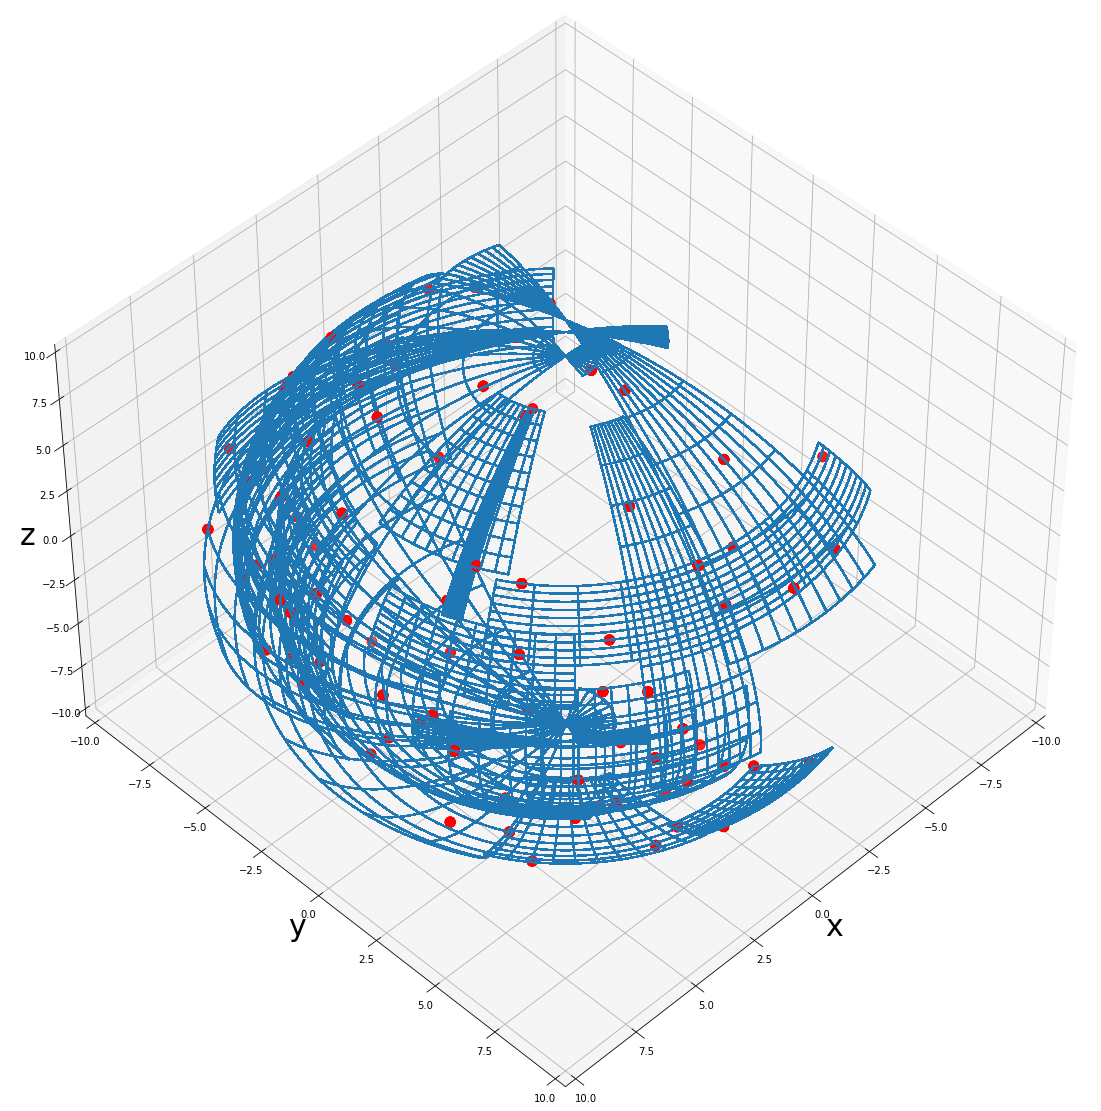

In [7]:
ellipsoid_test = ellipsoid(if_draw=True)


for j in range(small_bunch_list.shape[0]-1):
    alpha, beta = np.random.normal(0, 1, 2)
    number_of_random_points = 5
    interval = 3
    random_normal_coordinates, x, y, z = make_small_grape_bunch(small_bunch_list[j], alpha, beta, number_of_random_points, interval)
    
    
    for i in range(len(random_normal_coordinates)-1):
        start_point = np.array([[0, 0, 0]])
        center_of_piece = np.array([random_normal_coordinates[i]])
        unit_ellipsoid_axes, radius_list = grape_piece_moment(start_point, center_of_piece)
        ellipsoid_test.draw_ellipsoid(unit_ellipsoid_axes, radius_list, center_of_piece)
        ellipsoid_test.draw_film(x, y, z, random_normal_coordinates)
    
    ellipsoid_test.draw_film(x, y, z, random_normal_coordinates)
    
ellipsoid_test.show()
    